In [3]:
from ast import arg
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import sys
import logging
import requests


import pyspark.sql.functions as f






In [1]:
company_stock_symbol = input() #Enter the company stock symbol for prediction

 IBM


In [8]:
# Get data from API sources for specific keys
def write_url_to_csv(url, csv_filename):
    try:
        # Make a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

        # Parse the content as text and split it into lines
        lines = response.text.splitlines()

        # Assuming the content is CSV, you can use the csv.reader to parse it
        csv_data = csv.reader(lines)

        # Write the CSV data to a file
        with open(csv_filename, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerows(csv_data)

        print(f"CSV data from {url} written to {csv_filename} successfully.")

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")

url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={company_stock_symbol}&apikey=demo&datatype=csv"

write_url_to_csv(url,f"daily_adjusted_{company_stock_symbol}.csv")

# print(data)

In [4]:
spark = SparkSession.builder.appName("StockPrediction").master("local[*]").config("spark.executor.memory", "6gb").getOrCreate()
# Load the data from the CSV into a DataFrame
df = spark.read.csv(f"daily_adjusted_{company_stock_symbol}.csv", header=True, inferSchema=True)


In [7]:
# Data Cleaning and Analysis
df = df.withColumn('date', f.to_date('timestamp'))

date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, f.split('date', '-')[index])

df.show()

+----------+------+--------+--------+------+--------------+-------+---------------+-----------------+----------+----+-----+---+
| timestamp|  open|    high|     low| close|adjusted_close| volume|dividend_amount|split_coefficient|      date|year|month|day|
+----------+------+--------+--------+------+--------------+-------+---------------+-----------------+----------+----+-----+---+
|2023-12-11|162.68|  163.65|  161.95|163.51|        163.51|6077207|            0.0|              1.0|2023-12-11|2023|   12| 11|
|2023-12-08| 160.0|  162.04|   160.0|161.96|        161.96|4561342|            0.0|              1.0|2023-12-08|2023|   12| 08|
|2023-12-07| 161.0| 161.465|  159.97|160.22|        160.22|3665498|            0.0|              1.0|2023-12-07|2023|   12| 07|
|2023-12-06|161.59| 162.355|  160.01|160.28|        160.28|3356432|            0.0|              1.0|2023-12-06|2023|   12| 06|
|2023-12-05|160.76|  162.47|  160.72|161.39|        161.39|4556668|            0.0|              1.0|202

In [6]:
df.groupBy(['year']).agg({'adjusted_close':'count'})\
    .withColumnRenamed('count(adjusted_close)', 'Row Count')\
    .orderBy(["year"],ascending=False)\
    .show()

+----+---------+
|year|Row Count|
+----+---------+
|2023|      100|
+----+---------+



In [12]:


df.select('open', 'high', 'low', 'close', 'adjusted_close','dividend_amount').describe().show()



+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|              open|              high|               low|             close|    adjusted_close|     dividend_amount|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|              5273|              5273|              5273|              5273|              5273|                5273|
|   mean|147.57249478475308|148.44671111321813|146.57975759529677|147.55787494784704|125.00964741134094|0.010554636829129526|
| stddev| 49.24058658693661| 49.26722812899501| 49.20253052783717| 49.24062827847611|  56.6606279783604| 0.09076239069518781|
|    min|             67.95|              70.0|              67.1|             68.11|           55.8476|                 0.0|
|    max|            293.09|            293.94|            291.81|            293.58|          292.2562|              

In [60]:
# Window function to order by date (for features that require looking at previous rows)
w = Window.partitionBy().orderBy("timestamp")d

# Feature Engineering
# 1. Create a lagged column for the 'close' price (i.e., previous day's close)
df = df.withColumn("lag_close_1", F.lag(df.close).over(w))

# 2. Calculate daily return - how much did the price change in percentage from opening to closing
df = df.withColumn("daily_return", (df.close - df.open) / df.open)

# 3. Calculate intra-day volatility - difference between the highest and lowest prices of the day
df = df.withColumn("intra_day_volatility", df.high - df.low)

# 4. Calculate daily volatility - change in closing price from the previous day
df = df.withColumn("daily_volatility", df.close - df.lag_close_1)

# 5. Calculate a 7-day moving average for the closing prices
df = df.withColumn("7_day_avg_close", F.avg(df.close).over(w.rowsBetween(-6, 0)))

# 6. Binary indicator if there was a dividend
df = df.withColumn("is_dividend", F.when(df["dividend_amount"] > 0, 1).otherwise(0))

# 7. Binary indicator if there was a stock split
df = df.withColumn("is_split", F.when(df["split_coefficient"] != 1, 1).otherwise(0))

In [61]:
# Drop any rows with NA values (which might have been introduced due to lagging operations)d
df = df.dropna()

# Assemble the features into a single vector for MLlib consumption
feature_columns = ["open", "high", "low", "close", "volume", "daily_return", 
				"intra_day_volatility", "daily_volatility", "7_day_avg_close", 
				"is_dividend", "is_split"]

In [62]:
df.show()

+----------+------+-------+--------+------+----------------+-------+---------------+-----------------+-----------+--------------------+--------------------+--------------------+------------------+-----------+--------+
| timestamp|  open|   high|     low| close|  adjusted_close| volume|dividend_amount|split_coefficient|lag_close_1|        daily_return|intra_day_volatility|    daily_volatility|   7_day_avg_close|is_dividend|is_split|
+----------+------+-------+--------+------+----------------+-------+---------------+-----------------+-----------+--------------------+--------------------+--------------------+------------------+-----------+--------+
|2023-07-24|139.35| 140.12|138.7788|139.54|136.388921815193|3475442|            0.0|              1.0|     138.94|0.001363473268747741|  1.3412000000000148|  0.5999999999999943|            139.24|          0|       0|
|2023-07-25|139.42| 140.43|139.0403|140.33|137.161082114993|3770813|            0.0|              1.0|     139.54|0.006527040596

In [63]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

# Split the data into a training set and a test set. 
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(df_assembled.count() * 0.8)
train_data = df_assembled.orderBy("timestamp").limit(train_count)
test_data = df_assembled.subtract(train_data)

In [64]:
# Model Training
# Gradient Boosted Trees are chosen due to their robustness and ability to model non-linear patterns
# changed max iter to 100 -Root Mean Squared Error (RMSE) on test data = 55.641004384257215
# MAE: 44.57556949008952
# R2: -1.6967840653800321
gbt = GBTRegressor(labelCol="adjusted_close", featuresCol="features", maxIter=50)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

In [65]:
# Model Evaluation
# Compute the RMSE (Root Mean Squared Error) for the predictions
evaluator_rmse = RegressionEvaluator(labelCol="adjusted_close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Compute other metrics: Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
	evaluator = RegressionEvaluator(labelCol="adjusted_close", predictionCol="prediction", metricName=metric)
	value = evaluator.evaluate(predictions)
	print("{0}: {1}".format(metric.upper(),value))

Root Mean Squared Error (RMSE) on test data = 9.544595132509585
MAE: 8.734564548282654
R2: -4.40344806670358


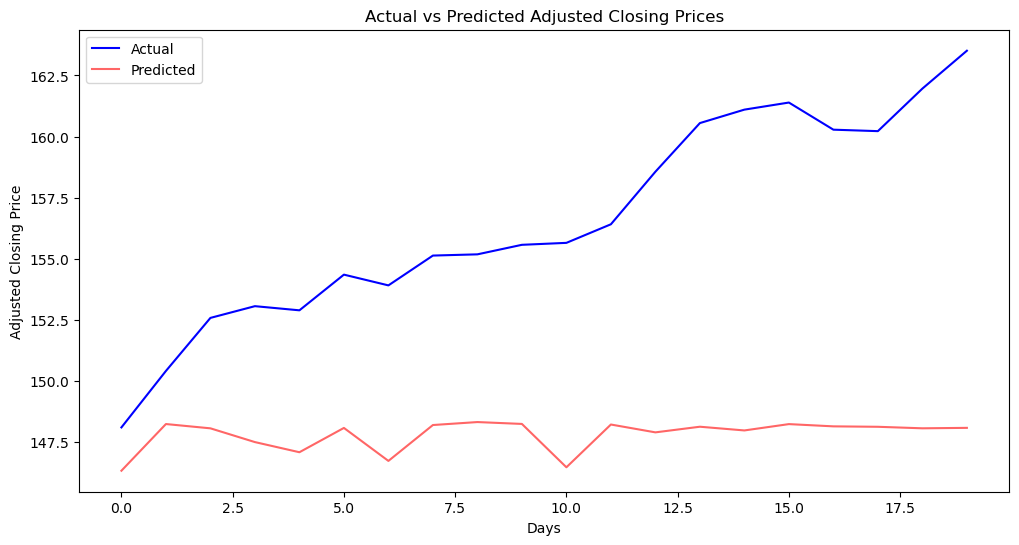

In [66]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("adjusted_close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["adjusted_close"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

In [27]:
# predictions.write.csv(path='output/stock_predictions.csv')

In [58]:
# Terminate the Spark session
spark.stop()